In [1]:
import kagglehub
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import os
from keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random

nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Part 1

In [2]:
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
print(f"IMDB data path: {path}")

if not os.path.exists("glove.6B.100d.txt"):
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip glove.6B.100d.txt
  !rm glove.6B.zip

print("Creating embedding index...")
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

IMDB data path: /root/.cache/kagglehub/datasets/PromptCloudHQ/imdb-data/versions/1
Creating embedding index...
Found 400000 word vectors.


## Load Data

In [3]:
data = pd.read_csv(f"{path}/IMDB-Movie-Data.csv")

## Preprocess Data

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
tokens = data["Description"].apply(lambda row: [
    embeddings_index.get(lemmatizer.lemmatize(t.lower()), np.zeros(100))
    for t in nltk.word_tokenize(row)
    if t.lower() not in stop_words and t.isalnum()])
padded_tokens = pad_sequences(tokens, maxlen=50, dtype="float32", padding="post", truncating="post", value=0.0)
mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(data["Genre"].apply(lambda x: x.split(",")))

X_train, X_temp, y_train, y_temp = train_test_split(padded_tokens, encoded_genres, train_size=700, random_state=67)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=100, random_state=420)

## Helper Plotting Function

In [5]:
def plot_metrics(history, title):
  # Extract metrics from history
  train_loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  train_acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  train_recall = history.history["recall"]
  val_recall = history.history["val_recall"]
  train_precision = [np.mean(f1) for f1 in history.history["precision"]]
  val_precision = [np.mean(f1) for f1 in history.history["val_precision"]]


  # Epochs range
  epochs = range(1, len(train_loss) + 1)

  # Plot Loss
  plt.figure(figsize=(8, 8))
  plt.suptitle(f"Metrics for {title}")

  plt.subplot(2, 2, 1)
  plt.plot(epochs, train_loss, "b-", label="Training Loss")
  plt.plot(epochs, val_loss, "r-", label="Validation Loss")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Plot Accuracy
  plt.subplot(2, 2, 2)
  plt.plot(epochs, train_acc, "b-", label="Training Accuracy")
  plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(epochs, train_recall, "b-", label="Training Recall")
  plt.plot(epochs, val_recall, "r-", label="Validation Recall")
  plt.title("Training and Validation Recall")
  plt.xlabel("Epochs")
  plt.ylabel("Recall")
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(epochs, train_precision, "b-", label="Training Precision")
  plt.plot(epochs, val_precision, "r-", label="Validation Precision")
  plt.title("Training and Validation Precision")
  plt.xlabel("Epochs")
  plt.ylabel("Precision")
  plt.legend()

  plt.tight_layout()
  plt.show()

## Simple RNN

In [6]:
basic_rnn = keras.Sequential([
    layers.Input(shape=(50, 100)),
    layers.SimpleRNN(32),
    layers.Dense(20, activation="sigmoid")
])

basic_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "precision", "recall"])
rnn_history = basic_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

#plot_metrics(history, "Simple RNN")

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.0401 - loss: 0.6576 - precision: 0.1538 - recall: 0.3800 - val_accuracy: 0.0500 - val_loss: 0.5654 - val_precision: 0.2034 - val_recall: 0.2857
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1671 - loss: 0.5154 - precision: 0.3392 - recall: 0.2340 - val_accuracy: 0.2400 - val_loss: 0.4186 - val_precision: 0.4118 - val_recall: 0.2222
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1621 - loss: 0.3903 - precision: 0.4038 - recall: 0.1249 - val_accuracy: 0.2400 - val_loss: 0.3536 - val_precision: 0.4661 - val_recall: 0.2183
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1878 - loss: 0.3518 - precision: 0.4135 - recall: 0.1626 - val_accuracy: 0.2300 - val_loss: 0.3519 - val_precision: 0.4118 - val_recall: 0.2222
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1890 - loss: 0.3448 - precision: 0.4378 - recall: 0.1901 - val_accuracy: 0.2300 - val_loss: 0.3483 - 

## LSTM

In [7]:
lstm = keras.Sequential([
    layers.Input(shape=(50, 100)),
    layers.LSTM(32),
    layers.Dense(20, activation="sigmoid")
])

lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "precision", "recall"])
lstm_history = lstm.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

#plot_metrics(history, "LSTM")

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1393 - loss: 0.6854 - precision: 0.2447 - recall: 0.3682 - val_accuracy: 0.2300 - val_loss: 0.6101 - val_precision: 0.3183 - val_recall: 0.3929
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1584 - loss: 0.5299 - precision: 0.2563 - recall: 0.3433 - val_accuracy: 0.2400 - val_loss: 0.3726 - val_precision: 0.5400 - val_recall: 0.2143
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1840 - loss: 0.3699 - precision: 0.5000 - recall: 0.1930 - val_accuracy: 0.2400 - val_loss: 0.3260 - val_precision: 0.5400 - val_recall: 0.2143
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1942 - loss: 0.3312 - precision: 0.5029 - recall: 0.1046 - val_accuracy: 0.2400 - val_loss: 0.3160 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1877 - loss: 0.3247 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2400 - v

## Testing

In [8]:
print("RNN", rnn_stats := basic_rnn.evaluate(X_test, y_test, return_dict=True))
print("LSTM", lstm_stats := lstm.evaluate(X_test, y_test, return_dict=True))

print()
print("-" * 100)
print()

tokens_with_title = data[["Title", "Description"]].apply(lambda row: " ".join(row), axis=1).apply(lambda row: [
    embeddings_index.get(lemmatizer.lemmatize(t.lower()), np.zeros(100))
    for t in nltk.word_tokenize(row)
    if t.lower() not in stop_words and t.isalnum()])
padded_tokens_with_title = pad_sequences(tokens_with_title, maxlen=50, dtype="float32", padding="post", truncating="post", value=0.0)

_, X_temp2, _, y_temp2 = train_test_split(padded_tokens_with_title, encoded_genres, train_size=700, random_state=67)
_, X_test2, _, y_test2 = train_test_split(X_temp, y_temp, train_size=100, random_state=420)

print("RNN", rnn_title_stats := basic_rnn.evaluate(X_test2, y_test2, return_dict=True))
print("LSTM", lstm_title_stats := lstm.evaluate(X_test2, y_test2, return_dict=True))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.1894 - loss: 0.3392 - precision: 0.1283 - recall: 0.0171
RNN {'accuracy': 0.2150000035762787, 'loss': 0.32634133100509644, 'precision': 0.1315789520740509, 'recall': 0.009980039671063423}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1894 - loss: 0.3037 - precision: 0.0000e+00 - recall: 0.0000e+00
LSTM {'accuracy': 0.2150000035762787, 'loss': 0.3063218295574188, 'precision': 0.0, 'recall': 0.0}

----------------------------------------------------------------------------------------------------

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1894 - loss: 0.3392 - precision: 0.1283 - recall: 0.0171 
RNN {'accuracy': 0.2150000035762787, 'loss': 0.32634133100509644, 'precision': 0.1315789520740509, 'recall': 0.009980039671063423}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1894 - loss: 0.3037 - precision: 0.0000e+00 - recall: 0.0000e+00 
LSTM {'accuracy': 0.2150000035762787, 'loss': 0.3063218295574188, 'precision': 0.0,

# Part 2

In [9]:
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


## Load Data

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{path}/seg_train/seg_train",
    labels="inferred",
    label_mode="categorical",
    image_size=(150, 150),
    interpolation="nearest",
    batch_size=32,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{path}/seg_test/seg_test",
    labels="inferred",
    label_mode="categorical",
    image_size=(150, 150),
    interpolation="nearest",
    batch_size=32,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.



## CNN (3 Conv Layers)

In [11]:
def run_cnn3(alpha, batch_size, optimizer):
  print(f"Testing CNN3 w/ alpha={alpha}, batch_size={batch_size}, optimizer='{optimizer}'")
  cnn3 = keras.Sequential([
      layers.Input(shape=(150, 150, 3)),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(6, activation="softmax")
  ])

  cnn3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "precision", "recall"])
  history = cnn3.fit(train_ds, epochs=10, validation_data=val_ds, batch_size=batch_size)

  results = cnn3.evaluate(val_ds, return_dict=True)

  y_true = tf.concat([y for x, y in val_ds], axis=0)
  y_pred = cnn3.predict(val_ds)
  y_pred_classes = tf.argmax(y_pred, axis=1)
  y_true_classes = tf.argmax(y_true, axis=1)

  class_names = val_ds.class_names
  per_class_accuracy = {}
  for i, class_name in enumerate(class_names):
      class_mask = (y_true_classes == i)
      class_true = tf.boolean_mask(y_true_classes, class_mask)
      class_pred = tf.boolean_mask(y_pred_classes, class_mask)
      accuracy = tf.reduce_mean(tf.cast(class_true == class_pred, tf.float32))
      per_class_accuracy[class_name] = accuracy.numpy()

  results["classes"] = per_class_accuracy

  results["samples"] = [
      {
          "image": xs[0],
          "prediction": cnn3.predict(xs)[0],
          "actual": ys[0]
      }
      for xs, ys in [
          val_ds.skip(random.randrange(0, len(val_ds))).take(1).as_numpy_iterator().next(),
          val_ds.skip(random.randrange(0, len(val_ds))).take(1).as_numpy_iterator().next(),
      ]
  ]

  return history, results

cnn3s = [None] * 4

In [12]:
cnn3s[0] = run_cnn3(alpha=0.001, batch_size=32, optimizer="adam")

Testing CNN3 w/ alpha=0.001, batch_size=32, optimizer='adam'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.4113 - loss: 4.9990 - precision: 0.5252 - recall: 0.2211 - val_accuracy: 0.6303 - val_loss: 1.0005 - val_precision: 0.7337 - val_recall: 0.4647
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6259 - loss: 0.9648 - precision: 0.7270 - recall: 0.4966 - val_accuracy: 0.6790 - val_loss: 0.8842 - val_precision: 0.7507 - val_recall: 0.5760
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7014 - loss: 0.7911 - precision: 0.7663 - recall: 0.6084 - val_accuracy: 0.7107 - val_loss: 0.8159 - val_precision: 0.7618 - val_recall: 0.6407
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7586 - loss: 0.6595 - precision: 0.8040 - recall: 0.6960 - val_accuracy: 0.7327 - val_loss: 0.7766 - val_precision: 0.7673 - val_recall: 0.6693
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7952 - loss: 0.5673 - p

In [13]:
cnn3s[1] = run_cnn3(alpha=0.01, batch_size=64, optimizer="adam")

Testing CNN3 w/ alpha=0.01, batch_size=64, optimizer='adam'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.3285 - loss: 6.5409 - precision: 0.4352 - recall: 0.1177 - val_accuracy: 0.4737 - val_loss: 1.3403 - val_precision: 0.7179 - val_recall: 0.2070
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4989 - loss: 1.2954 - precision: 0.6894 - recall: 0.2584 - val_accuracy: 0.5687 - val_loss: 1.1652 - val_precision: 0.7726 - val_recall: 0.2787
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5200 - loss: 1.1874 - precision: 0.7185 - recall: 0.3095 - val_accuracy: 0.5620 - val_loss: 1.1794 - val_precision: 0.6588 - val_recall: 0.3837
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6056 - loss: 1.0060 - precision: 0.7385 - recall: 0.4473 - val_accuracy: 0.6493 - val_loss: 0.9241 - val_precision: 0.7316 - val_recall: 0.5023
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6512 - loss: 0.9016 - pr

In [14]:
cnn3s[2] = run_cnn3(alpha=0.001, batch_size=32, optimizer="rmsprop")

Testing CNN3 w/ alpha=0.001, batch_size=32, optimizer='rmsprop'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.3268 - loss: 8.5225 - precision: 0.3953 - recall: 0.1380 - val_accuracy: 0.5200 - val_loss: 1.2247 - val_precision: 0.7130 - val_recall: 0.2683
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5507 - loss: 1.2084 - precision: 0.6797 - recall: 0.3541 - val_accuracy: 0.5733 - val_loss: 1.2871 - val_precision: 0.6432 - val_recall: 0.4530
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.6397 - loss: 0.9783 - precision: 0.7216 - recall: 0.5225 - val_accuracy: 0.7050 - val_loss: 0.8929 - val_precision: 0.7473 - val_recall: 0.6457
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7172 - loss: 0.8136 - precision: 0.7746 - recall: 0.6412 - val_accuracy: 0.6683 - val_loss: 0.9817 - val_precision: 0.7288 - val_recall: 0.6047
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7477 - loss: 0.7236 

In [15]:
cnn3s[3] = run_cnn3(alpha=0.01, batch_size=64, optimizer="rmsprop")

Testing CNN3 w/ alpha=0.01, batch_size=64, optimizer='rmsprop'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.3459 - loss: 8.4654 - precision: 0.4309 - recall: 0.1729 - val_accuracy: 0.5463 - val_loss: 1.1882 - val_precision: 0.7738 - val_recall: 0.2247
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5508 - loss: 1.1976 - precision: 0.6785 - recall: 0.3561 - val_accuracy: 0.5907 - val_loss: 1.0826 - val_precision: 0.6856 - val_recall: 0.4433
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6358 - loss: 0.9951 - precision: 0.7178 - recall: 0.4945 - val_accuracy: 0.6853 - val_loss: 0.8967 - val_precision: 0.7740 - val_recall: 0.5560
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6816 - loss: 0.8834 - precision: 0.7502 - recall: 0.5802 - val_accuracy: 0.6433 - val_loss: 1.1452 - val_precision: 0.6739 - val_recall: 0.6013
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7219 - loss: 0.7912 -

## CNN (6 Conv Layers)

In [16]:
def run_cnn6(alpha, batch_size, optimizer):
  print(f"Testing CNN6 w/ alpha={alpha}, batch_size={batch_size}, optimizer='{optimizer}'")
  cnn6 = keras.Sequential([
      layers.Input(shape=(150, 150, 3)),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.Conv2D(32, 3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(6, activation="softmax")
  ])

  cnn6.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "precision", "recall"])
  history = cnn6.fit(train_ds, epochs=10, validation_data=val_ds, batch_size=batch_size)

  results = cnn6.evaluate(val_ds, return_dict=True)

  # Get true labels and predictions for per-class accuracy
  y_true = tf.concat([y for x, y in val_ds], axis=0)
  y_pred = cnn6.predict(val_ds)
  y_pred_classes = tf.argmax(y_pred, axis=1)
  y_true_classes = tf.argmax(y_true, axis=1)

  class_names = val_ds.class_names
  per_class_accuracy = {}
  for i, class_name in enumerate(class_names):
      class_mask = (y_true_classes == i)
      class_true = tf.boolean_mask(y_true_classes, class_mask)
      class_pred = tf.boolean_mask(y_pred_classes, class_mask)
      accuracy = tf.reduce_mean(tf.cast(class_true == class_pred, tf.float32))
      per_class_accuracy[class_name] = accuracy.numpy()

  results["classes"] = per_class_accuracy

  results["samples"] = [
      {
          "image": xs[0],
          "prediction": cnn6.predict(xs)[0],
          "actual": ys[0]
      }
      for xs, ys in [
          val_ds.skip(random.randrange(0, len(val_ds))).take(1).as_numpy_iterator().next(),
          val_ds.skip(random.randrange(0, len(val_ds))).take(1).as_numpy_iterator().next(),
      ]
  ]

  return history, results

cnn6s = [None] * 4

In [17]:
cnn6s[0] = run_cnn6(alpha=0.001, batch_size=32, optimizer="adam")

Testing CNN6 w/ alpha=0.001, batch_size=32, optimizer='adam'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.4822 - loss: 2.4174 - precision: 0.5846 - recall: 0.3119 - val_accuracy: 0.6640 - val_loss: 0.8409 - val_precision: 0.7027 - val_recall: 0.5893
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7133 - loss: 0.7602 - precision: 0.7735 - recall: 0.6241 - val_accuracy: 0.7547 - val_loss: 0.6618 - val_precision: 0.8015 - val_recall: 0.6850
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7667 - loss: 0.6303 - precision: 0.8119 - recall: 0.7097 - val_accuracy: 0.7417 - val_loss: 0.6867 - val_precision: 0.8090 - val_recall: 0.6437
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7909 - loss: 0.5596 - precision: 0.8307 - recall: 0.7483 - val_accuracy: 0.7980 - val_loss: 0.5938 - val_precision: 0.8401 - val_recall: 0.7373
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8250 - loss: 0.4955 - p

In [18]:
cnn6s[1] = run_cnn6(alpha=0.01, batch_size=64, optimizer="adam")

Testing CNN6 w/ alpha=0.01, batch_size=64, optimizer='adam'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.4810 - loss: 2.1353 - precision: 0.6070 - recall: 0.3074 - val_accuracy: 0.7150 - val_loss: 0.7692 - val_precision: 0.7881 - val_recall: 0.6237
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7263 - loss: 0.7269 - precision: 0.7858 - recall: 0.6464 - val_accuracy: 0.7740 - val_loss: 0.6669 - val_precision: 0.8270 - val_recall: 0.6930
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7701 - loss: 0.6275 - precision: 0.8118 - recall: 0.7105 - val_accuracy: 0.7830 - val_loss: 0.6190 - val_precision: 0.8256 - val_recall: 0.7227
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8052 - loss: 0.5377 - precision: 0.8391 - recall: 0.7636 - val_accuracy: 0.7800 - val_loss: 0.6350 - val_precision: 0.8088 - val_recall: 0.7447
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8275 - loss: 0.4807 - pr

In [19]:
cnn6s[2] = run_cnn6(alpha=0.01, batch_size=32, optimizer="rmsprop")

Testing CNN6 w/ alpha=0.01, batch_size=32, optimizer='rmsprop'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.4130 - loss: 3.5899 - precision: 0.5414 - recall: 0.2126 - val_accuracy: 0.6963 - val_loss: 0.8316 - val_precision: 0.7845 - val_recall: 0.5460
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6915 - loss: 0.8241 - precision: 0.7684 - recall: 0.5936 - val_accuracy: 0.7263 - val_loss: 0.8752 - val_precision: 0.7663 - val_recall: 0.6667
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7612 - loss: 0.6754 - precision: 0.8079 - recall: 0.7029 - val_accuracy: 0.7797 - val_loss: 0.6270 - val_precision: 0.8109 - val_recall: 0.7477
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7964 - loss: 0.5721 - precision: 0.8271 - recall: 0.7586 - val_accuracy: 0.7280 - val_loss: 0.9500 - val_precision: 0.7588 - val_recall: 0.6910
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8227 - loss: 0.4999 -

In [20]:
cnn6s[3] = run_cnn6(alpha=0.1, batch_size=64, optimizer="rmsprop")

Testing CNN6 w/ alpha=0.1, batch_size=64, optimizer='rmsprop'
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.4882 - loss: 2.5907 - precision: 0.6071 - recall: 0.3110 - val_accuracy: 0.6543 - val_loss: 0.8909 - val_precision: 0.7184 - val_recall: 0.5713
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7090 - loss: 0.7638 - precision: 0.7715 - recall: 0.6270 - val_accuracy: 0.7487 - val_loss: 0.6986 - val_precision: 0.8113 - val_recall: 0.6593
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7751 - loss: 0.6277 - precision: 0.8101 - recall: 0.7202 - val_accuracy: 0.7557 - val_loss: 0.7108 - val_precision: 0.7955 - val_recall: 0.7080
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8094 - loss: 0.5454 - precision: 0.8370 - recall: 0.7710 - val_accuracy: 0.8013 - val_loss: 0.5980 - val_precision: 0.8285 - val_recall: 0.7747
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8285 - loss: 0.4872 - 

# Report

## Part 1

### Plots

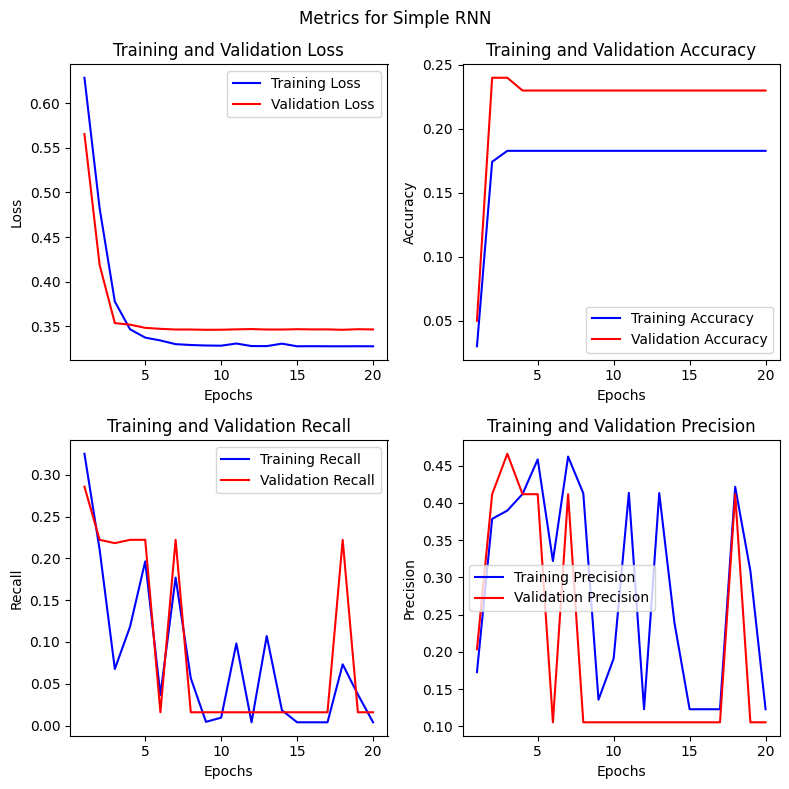

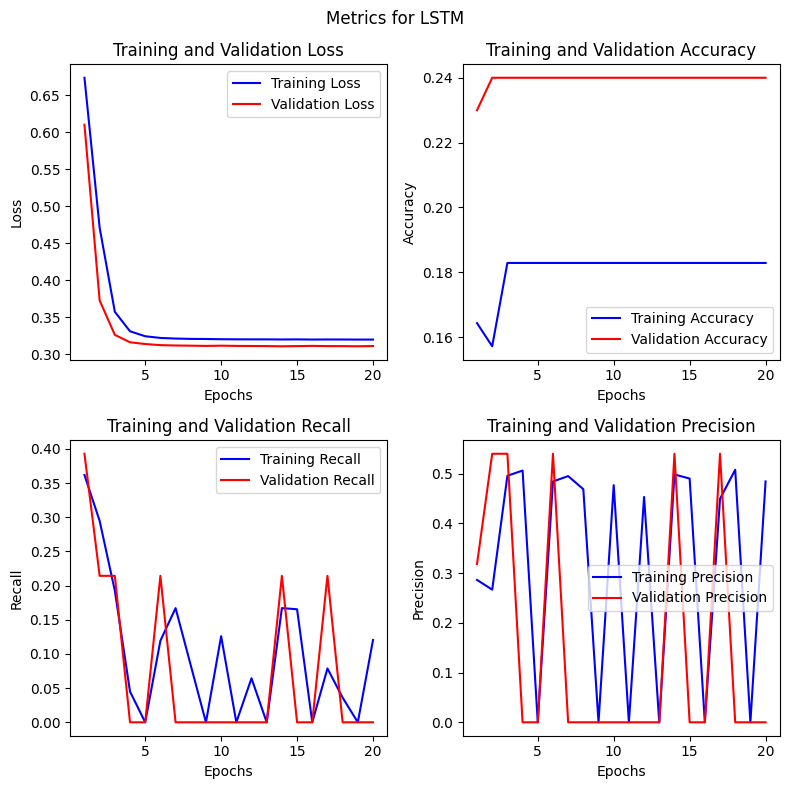

In [21]:
plot_metrics(rnn_history, "Simple RNN")
plot_metrics(lstm_history, "LSTM")

### Data

In [65]:
df = pd.DataFrame([rnn_stats, rnn_title_stats, lstm_stats, lstm_title_stats])
df.index = ["RNN", "RNN w/ Title", "LSTM", "LSTM w/ Title"]
df.drop(columns=["precision", "recall"], inplace=True)
df.rename(columns={"loss": "Loss", "accuracy": "Accuracy"}, inplace=True)
for c in df.columns:
  df[c] = df[c].apply(lambda x: f"{x * 100:.2f}%")

display(df)

,Accuracy,Loss
RNN,21.50%,32.63%
RNN w/ Title,21.50%,32.63%
LSTM,21.50%,30.63%
LSTM w/ Title,21.50%,30.63%


### Analysis

The RNN and LSTM achieved the same accuracies, but each model type had its own unique loss. Introducing the titles did not change anything about the results, which would imply that it did not help.

## Part 2

### Plots

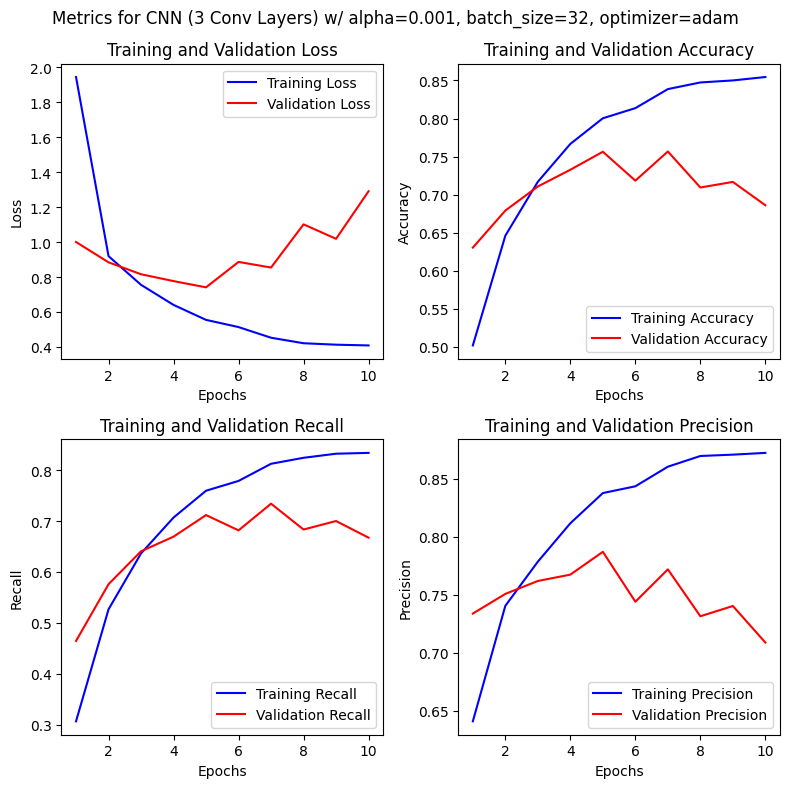

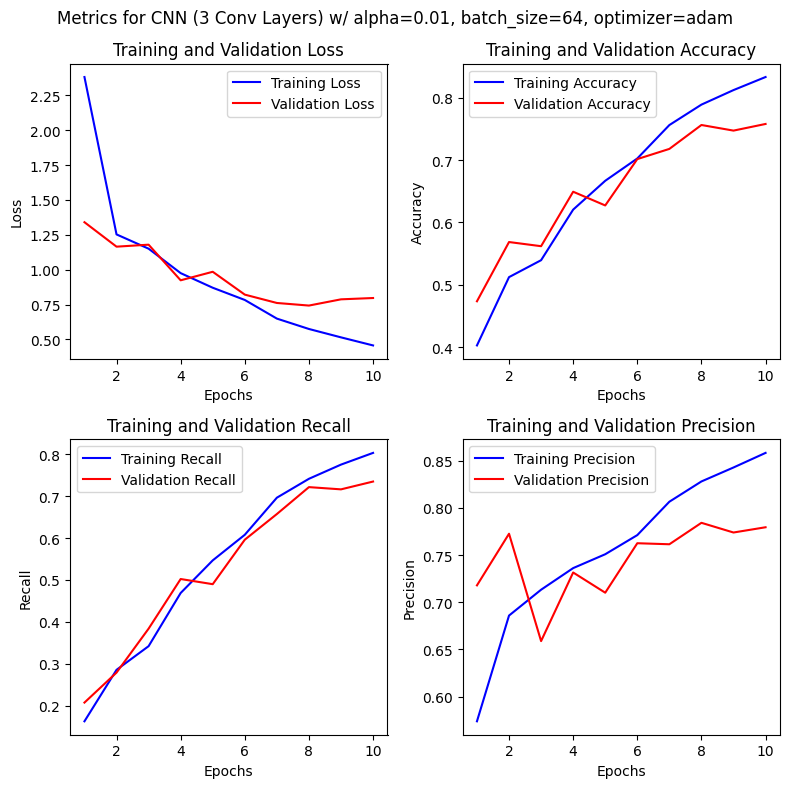

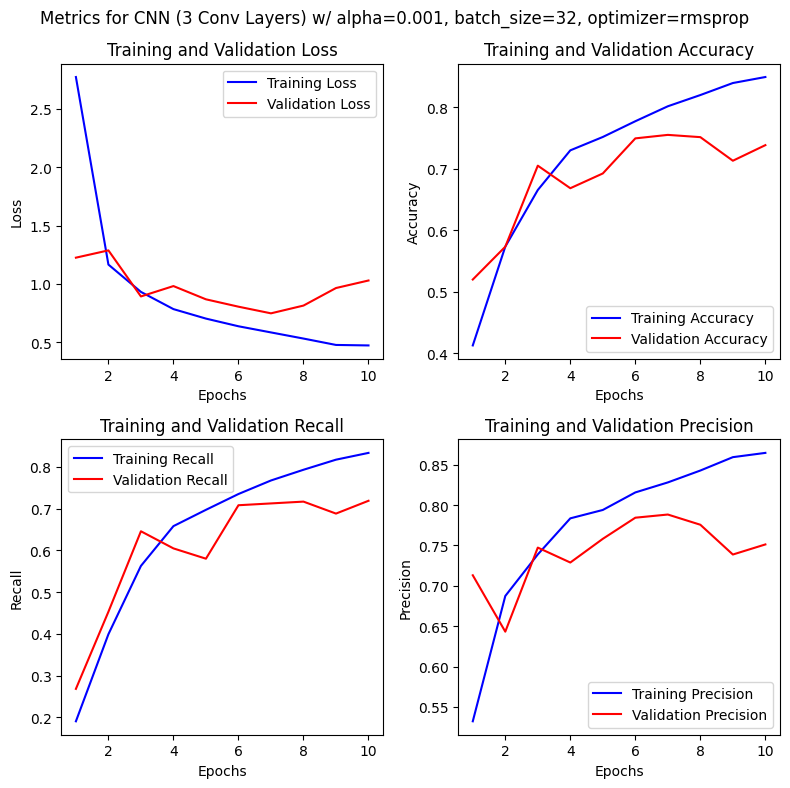

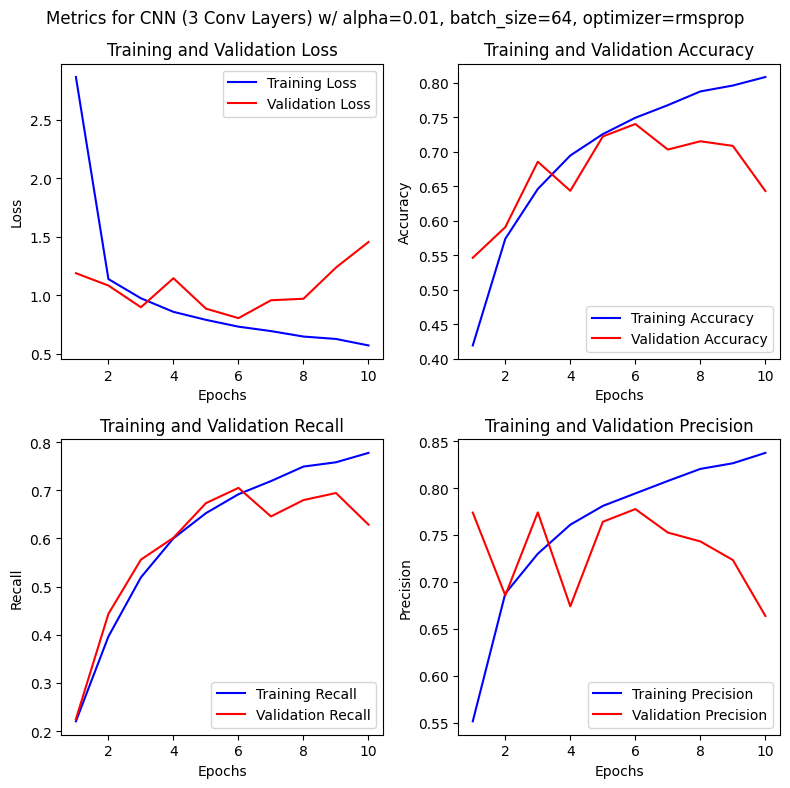

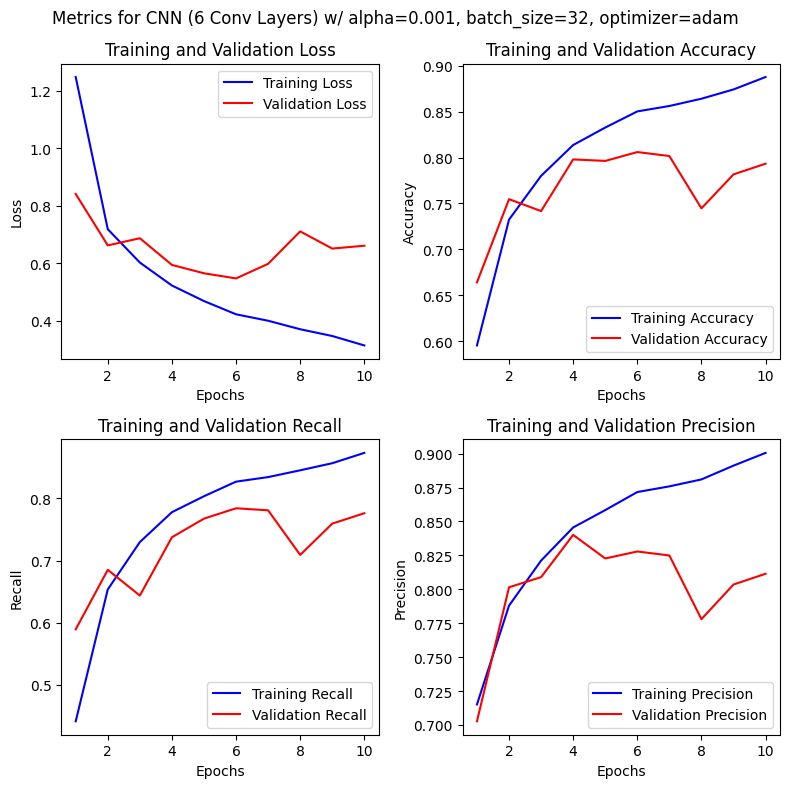

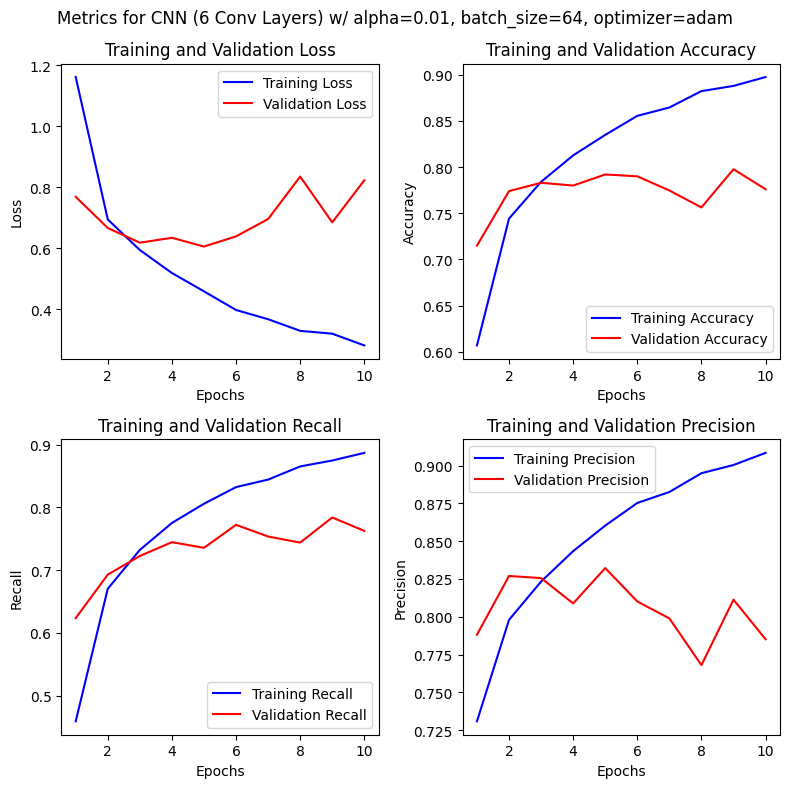

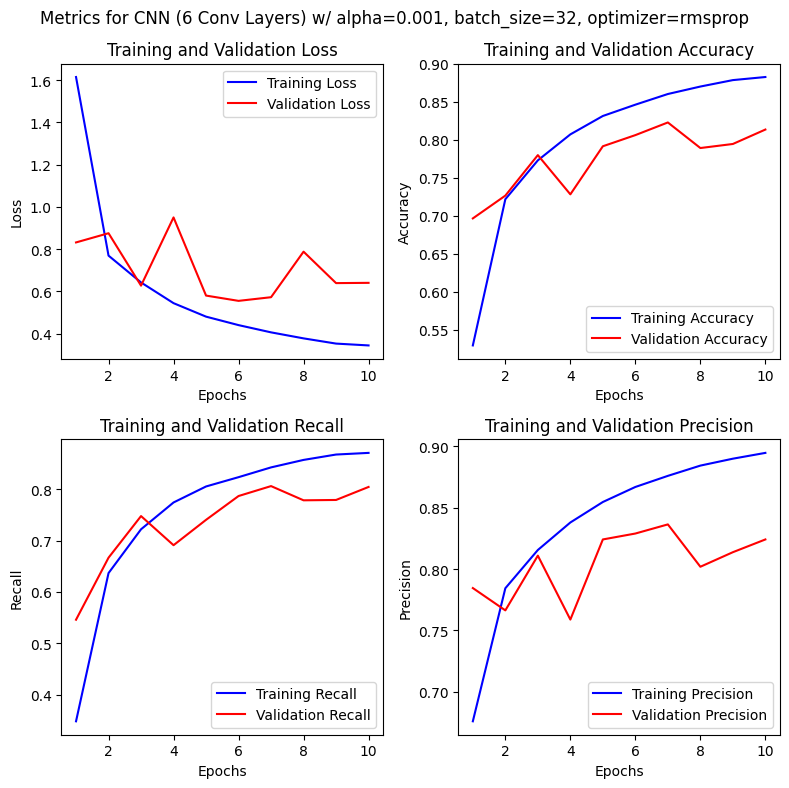

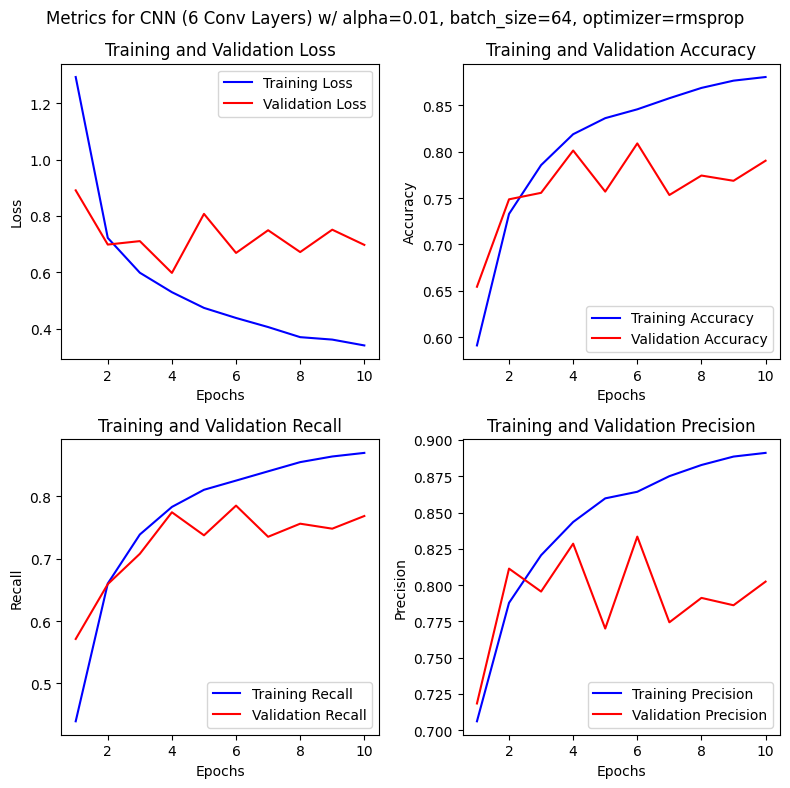

In [22]:
plot_metrics(cnn3s[0][0], "CNN (3 Conv Layers) w/ alpha=0.001, batch_size=32, optimizer=adam")
plot_metrics(cnn3s[1][0], "CNN (3 Conv Layers) w/ alpha=0.01, batch_size=64, optimizer=adam")
plot_metrics(cnn3s[2][0], "CNN (3 Conv Layers) w/ alpha=0.001, batch_size=32, optimizer=rmsprop")
plot_metrics(cnn3s[3][0], "CNN (3 Conv Layers) w/ alpha=0.01, batch_size=64, optimizer=rmsprop")

plot_metrics(cnn6s[0][0], "CNN (6 Conv Layers) w/ alpha=0.001, batch_size=32, optimizer=adam")
plot_metrics(cnn6s[1][0], "CNN (6 Conv Layers) w/ alpha=0.01, batch_size=64, optimizer=adam")
plot_metrics(cnn6s[2][0], "CNN (6 Conv Layers) w/ alpha=0.001, batch_size=32, optimizer=rmsprop")
plot_metrics(cnn6s[3][0], "CNN (6 Conv Layers) w/ alpha=0.01, batch_size=64, optimizer=rmsprop")

### Data

In [54]:
cnn_data = [result for _, result in cnn3s] + [result for _, result in cnn6s]
df = pd.DataFrame(cnn_data)

for class_name in df["classes"][0].keys():
  df[class_name.capitalize()] = df["classes"].apply(lambda x: f"{x[class_name] * 100:.2f}%")
df.drop("classes", axis=1, inplace=True)
df.drop("samples", axis=1, inplace=True)
df.drop(["loss", "precision", "recall"], axis=1, inplace=True)

df["accuracy"] = df["accuracy"].apply(lambda x: f"{x * 100:.2f}%")
df.rename(columns={"accuracy": "Overall Accuracy"}, inplace=True)

df.index = (models := [
    "CNN (3 Conv) w/ α=0.001, bs=32, o=adam",
    "CNN (3 Conv) w/ α=0.01, bs=64, o=adam",
    "CNN (3 Conv) w/ α=0.001, bs=32, o=rmsprop",
    "CNN (3 Conv) w/ α=0.01, bs=64, o=rmsprop",
    "CNN (6 Conv) w/ α=0.001, bs=32, o=adam",
    "CNN (6 Conv) w/ α=0.01, bs=64, o=adam",
    "CNN (6 Conv) w/ α=0.001, bs=32, o=rmsprop",
    "CNN (6 Conv) w/ α=0.01, bs=64, o=rmsprop"
])

display(df)

,Overall Accuracy,Buildings,Forest,Glacier,Mountain,Sea,Street
"CNN (3 Conv) w/ α=0.001, bs=32, o=adam",68.60%,80.78%,87.13%,40.51%,64.38%,72.94%,71.46%
"CNN (3 Conv) w/ α=0.01, bs=64, o=adam",75.80%,72.31%,89.03%,77.40%,73.52%,72.35%,70.46%
"CNN (3 Conv) w/ α=0.001, bs=32, o=rmsprop",73.83%,80.78%,89.66%,66.55%,70.67%,57.84%,80.44%
"CNN (3 Conv) w/ α=0.01, bs=64, o=rmsprop",64.30%,72.08%,71.73%,52.62%,40.19%,82.94%,69.66%
"CNN (6 Conv) w/ α=0.001, bs=32, o=adam",79.33%,78.03%,94.94%,67.27%,65.14%,89.61%,83.43%
"CNN (6 Conv) w/ α=0.01, bs=64, o=adam",77.60%,73.91%,90.72%,76.31%,80.19%,60.39%,84.63%
"CNN (6 Conv) w/ α=0.001, bs=32, o=rmsprop",81.33%,77.57%,94.73%,75.59%,82.86%,71.37%,86.83%
"CNN (6 Conv) w/ α=0.01, bs=64, o=rmsprop",79.03%,71.85%,94.51%,86.80%,68.38%,69.41%,83.03%


### Samples

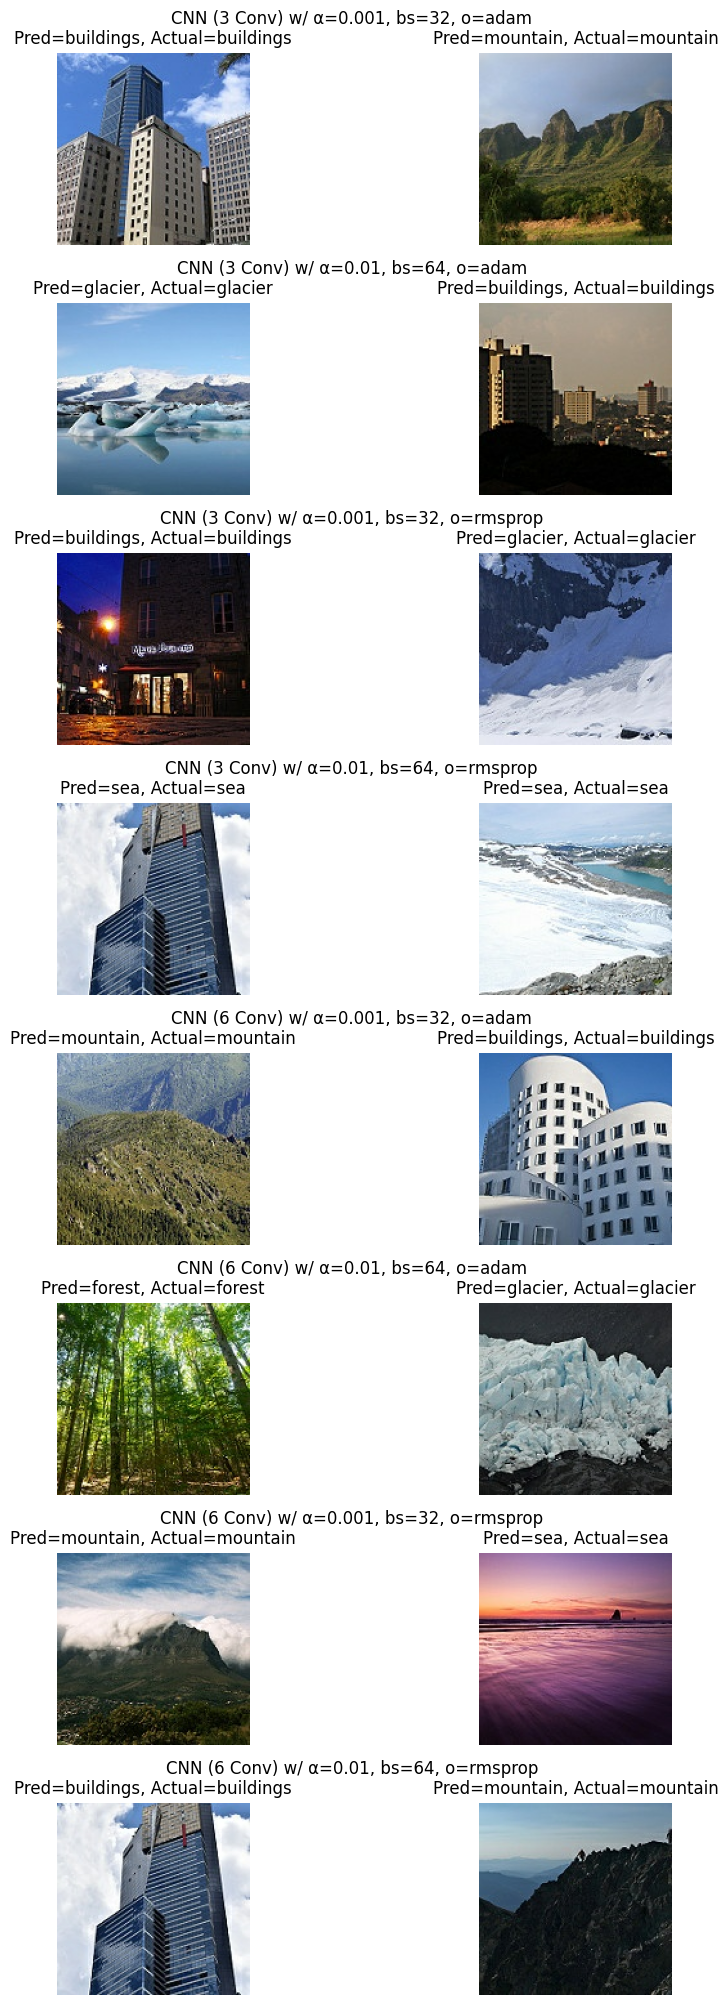

In [24]:
name = lambda x: val_ds.class_names[np.argmax(x)]
fig = plt.figure(figsize=(10, 20))
sf = fig.subfigures(8, 1)
for i, results in enumerate(cnn_data):
  row = sf[i]
  row.suptitle(models[i], y=1.05)
  axs = row.subplots(1, 2)
  for j, s in enumerate(results["samples"]):
    axs[j].set_title(f"Pred={name(s["prediction"])}, Actual={name(s["prediction"])}")
    axs[j].imshow(s["image"])
    axs[j].axis("off")